In [312]:
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import random

stop = stopwords.words('english')
lemma = WordNetLemmatizer()

In [2]:
df = pd.read_csv('mbti_1.csv')

# Clean data

https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

1. Lowercase and remove LINK
2. remove numeric and lemmatize words
3. store words in vocab to count each word occurence
4. remove rare words (i define rare word as word with word_count < 10)

In [10]:
# all lowercase and remove LINK
df.posts = df.posts.str.lower().str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')

In [46]:
# remove numeric and lemmatize words
results = {}
for row in tqdm_notebook(df.iterrows()):
    post = row[1]['posts']
    label = row[1]['type']
    
    post = re.sub('[^ a-zA-Z]', '', post)
    filtered = []
    for word in post.split():
        if word not in stop:
            filtered.append(lemma.lemmatize(word))
    results[' '.join(filtered)] = label

In [173]:
# create new df to store data
df2 = pd.DataFrame().from_dict(results, orient='index').reset_index()
df2 = df2.rename(columns={'index':'x', 0:'y'})

In [296]:
PAD = 0
class Vocab:
    def __init__(self):
        self.word2idx = {'<PAD>':PAD}
        self.idx2word = {PAD:'<PAD>'}
        self.word_count = {}
        
    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word[len(self.idx2word)] = word
            self.word2idx[word] = len(self.word2idx)
            self.word_count[word] = 1
        self.word_count[word] += 1
        
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)
            
    def __len__(self):
        return len(self.word2idx)

In [297]:
# to count words for removing rare words
# also can be used to create data (check data section on usage)
vocab = Vocab()
for sentence in df2.x:
    vocab.add_sentence(sentence)

In [298]:
# remove rare words
rare_words = [(k, vocab.word2idx[k]) for k,v in vocab.word_count.items() if v < 10]
for word, idx in rare_words:
    vocab.word2idx.pop(word)
    vocab.word_count.pop(word)
    vocab.idx2word.pop(idx)
df2.x = df2.x.apply(lambda x: ' '.join([i for i in x.split() if i in vocab.word2idx]))

# 4 labels

## Preprocess Data

#### Method 1

Suitable model
- tradition ML model (logistic regression, sgd classifier, SVM classifier etc)
- Feed forward neural network


1. apply Count vectorizer - to count word occurence in each sentence
2. apply tfidf
3. encode label into number
4. split dataset
5. Check imbalance dataset -> if imbalance, use undersampling or oversampling to handle it
6. training and evaluate
7. test



#### Method 2


suitable model
- lstm, rnn, gru (example of famous architecture -> seq2seq (typically used for machine translation))


1. create vocab -> store each word, associate with a unique index
2. for each sentence, tokenize the word, and convert the word into index (using the vocab class)
3. create model -> typically consist of embedding layer, rnn, and fully connected layer for classify
4. train by batch
5. Loss function for imbalance data -> https://datascience.stackexchange.com/questions/48369/what-loss-function-to-use-for-imbalanced-classes-using-pytorch

In [266]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to handle imbalance label
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [339]:
# Count Vectorizer explain - https://kavita-ganesan.com/how-to-use-countvectorizer/#.Xs8mEmgzZPY
# Tfidf explain - https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xs8l72gzZPY
count_vec = CountVectorizer(min_df=0.01, max_df=0.99)
tfidf_vec = TfidfTransformer()

In [340]:
X = df2.x.values
y = df2.y.values

In [341]:
X_vec = count_vec.fit_transform(X)
X_vec = tfidf_vec.fit_transform(X_vec)

In [243]:
# Create data label
label_map = {'I':0, 'E':1,
            'N':0, 'S':1,
            'T':0, 'F':1,
            'J':0, 'P':1}

IE_label = []
NS_label = []
TF_label = []
JP_label = []

for i in y:
    for idx, j in enumerate(i):
        if idx==0:
            IE_label.append(label_map[j])
        elif idx==1:
            NS_label.append(label_map[j])
        elif idx==2:
            TF_label.append(label_map[j])
        else:
            JP_label.append(label_map[j])

In [259]:
# split dataset
# train : 80%
# val : 10%
# test : 10%
X_train, X_val, IE_train, IE_val, NS_train, NS_val, TF_train, TF_val, JP_train, JP_val = train_test_split(X_vec, IE_label, NS_label, TF_label, JP_label, train_size=0.9)
X_train, X_test, IE_train, IE_test, NS_train, NS_test, TF_train, TF_test, JP_train, JP_test = train_test_split(X_train, IE_train, NS_train, TF_train, JP_train, train_size=0.9)

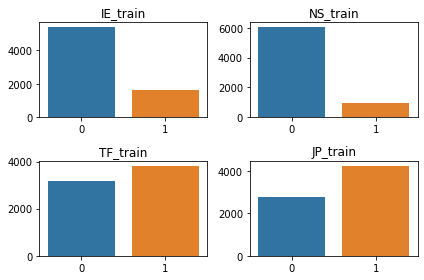

In [268]:
all_labels = [IE_train, NS_train, TF_train, JP_train]
titles = ['IE_train', 'NS_train', 'TF_train', 'JP_train']
for i in range(4):
    plt.subplot(2,2,i+1)
    count = dict(Counter(all_labels[i]))
    sns.barplot(list(count.keys()), list(count.values()))
    plt.title(titles[i])
plt.tight_layout()

As shown in graph above, IE and NS is imbalance, use undersampling or oversampling method to handle it

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

Another way to handle imbalance data - https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work

In [269]:
smote = SMOTE()
rus = RandomUnderSampler()

In [ ]:
# undersampling
X_train_res, IE_train_res = rus.fit_resample(X_train, IE_train)
####### training code here #######
##################################

X_train_res, NS_train_res = rus.fit_resample(X_train, NS_train)
####### training code here #######
##################################

# oversampling
X_train_res, IE_train_res = smote.fit_resample(X_train, IE_train)
####### training code here #######
##################################

X_train_res, NS_train_res = smote.fit_resample(X_train, NS_train)
####### training code here #######
##################################

## Method 2

Keras - https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

Pytorch - https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

In [271]:
# Create data label
label_map = {'I':0, 'E':1,
            'N':0, 'S':1,
            'T':0, 'F':1,
            'J':0, 'P':1}

IE_label = []
NS_label = []
TF_label = []
JP_label = []

for i in y:
    for idx, j in enumerate(i):
        if idx==0:
            IE_label.append(label_map[j])
        elif idx==1:
            NS_label.append(label_map[j])
        elif idx==2:
            TF_label.append(label_map[j])
        else:
            JP_label.append(label_map[j])

In [290]:
# convert each word to its respective index
def vectorize_data(data):
    results = []
    for sentence in data:
        sentence = sentence.split()
        temp = []
        for word in sentence:
            temp.append(vocab.word2idx[word])
        results.append(temp)
    return results

In [289]:
# create a custome dataloader to load by batch
class DataLoader:
    def __init__(self, data, label, batch_size):
        self.data = data
        self.label = label
        self.batch_size = batch_size
        self.n_batch = len(data) // self.batch_size
        
    def get_batch(self):
        batch_idxs = self.get_batch_idx()
        x = []
        y = []
        for idxs in batch_idxs:
            temp_x = []
            temp_y = []
            temp_len = []
            for idx in idxs:
                x_, y_ = self.get_item(idx)
                temp_x.append(torch.tensor(x_))
                temp_len.append(len(x_))
                temp_y.append(y_)
                
            # reference : https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
            temp_len, sort_idx = torch.sort(torch.tensor(temp_len), descending=True)
            temp_x = torch.nn.utils.rnn.pad_sequence(temp_x, batch_first=True)[sort_idx]
            temp_y = torch.tensor(temp_y)[sort_idx]
            yield temp_x, temp_y, temp_len
            
    def get_item(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        return x, y
    
    def get_batch_idx(self):
        idxs = list(range(self.__len__()))
        result_idxs = []
        for _ in range(self.n_batch):
            batch_idx = random.sample(idxs, self.batch_size)
            for idx in batch_idx:
                idxs.remove(idx)
            result_idxs.append(batch_idx)
        return result_idxs
        
    def __len__(self):
        return len(self.data)

In [302]:
vec_data = vectorize_data(X)

In [355]:
X_train, X_val, IE_train, IE_val, NS_train, NS_val, TF_train, TF_val, JP_train, JP_val = train_test_split(vec_data, IE_label, NS_label, TF_label, JP_label, train_size=0.9)
X_train, X_test, IE_train, IE_test, NS_train, NS_test, TF_train, TF_test, JP_train, JP_test = train_test_split(X_train, IE_train, NS_train, TF_train, JP_train, train_size=0.9)

In [367]:
# create data loader to get batch data
data_loader = DataLoader(X_train, IE_train, batch_size=32)
for x, y, x_len in data_loader.get_batch():
    break

NameError: name 'torch' is not defined

# 16 labels

## Method 1

In [266]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to handle imbalance label
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [331]:
# Count Vectorizer explain - https://kavita-ganesan.com/how-to-use-countvectorizer/#.Xs8mEmgzZPY
# Tfidf explain - https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xs8l72gzZPY
count_vec = CountVectorizer(min_df=0.01, max_df=0.99)
tfidf_vec = TfidfTransformer()

label_encoder = LabelEncoder()

In [299]:
X = df2.x.values
y = df2.y.values

In [235]:
X_vec = count_vec.fit_transform(X)
X_vec = tfidf_vec.fit_transform(X_vec)

In [332]:
y_vec = label_encoder.fit_transform(y)

In [336]:
X_train, X_val, y_train, y_val = train_test_split(X_vec, y_vec, train_size=0.9)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.9)

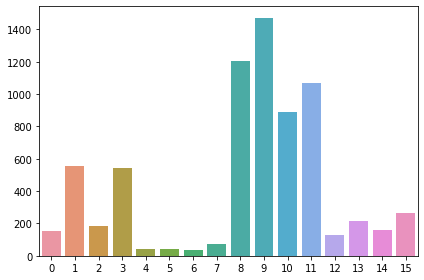

In [347]:
count = dict(Counter(y_train))
sns.barplot(list(count.keys()), list(count.values()))
plt.tight_layout()

Imbalance data too

option
1. undersampling or oversampling

2. modify class weight

In [343]:
# under sampling or over sampling
smote = SMOTE()
rus = RandomUnderSampler()

X_res, y_res = smote.fit_resample(X_train, y_train)
####### training code here #######
##################################

X_res, y_res = rus.fit_resample(X_train, y_train)
####### training code here #######
##################################

## Method 2

In [324]:
vec_data = vectorize_data(X)
unique_label = np.unique(y)
label2idx = dict(zip(unique_label, list(range(len(unique_label)))))
idx2label = dict(zip(list(range(len(unique_label))), unique_label))
vec_label = []
for i in y:
    vec_label.append(label2idx[i])

In [349]:
def plot(label):
    count = Counter(label)
    keys = np.array(list(count.keys()))
    keys2 = []
    for key in keys:
        keys2.append(idx2label[key])
    keys2 = np.array(keys2)
    values = np.array(list(count.values()))
    idx = np.argsort(values)
    sns.barplot(keys2[idx], values[idx])

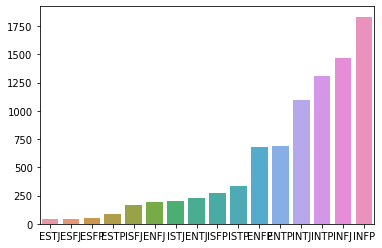

In [364]:
plot(vec_label)

imbalanced

In [362]:
train_data, val_data, train_label, val_label = train_test_split(vec_data, vec_label, train_size=0.9)
train_data, test_data, train_label, test_label = train_test_split(train_data, train_label, train_size=0.9)

In [366]:
data_loader = DataLoader(train_data, train_label, batch_size=32)